In [1]:
import pandas as pd
import numpy as np

# IPL Betting Models: Exploratory Notebook
This notebook is to explore the possibility of creating a betting models project.

The data has been taken from Kaggle (https://www.kaggle.com/datasets/vora1011/ipl-2008-to-2021-all-match-dataset) and looks at IPL (Indian Premier League) T20 matches. 

## Data Preprocessing:

- Handle missing values: Identify and handle missing values in your dataset. This could involve imputation or removal depending on the context.
- Encode categorical variables: Convert categorical variables into numerical format using techniques like one-hot encoding.
- Convert dates: If needed, convert date columns into numerical features that can be used by the model.

In [2]:
# import the ball by ball csv file from Kaggle. This is ball by ball data of what happened in every match since 2008 until 2022.

ball_by_ball_df = pd.read_csv('../raw_data/IPL_Ball_by_Ball_2008_2022.csv')

In [3]:
# ball by ball is not particularly useful. We want to calculate the innings total. For this we must group by id and calculate the total runs for each innings. 

ball_by_ball_df['innings_total'] = ball_by_ball_df.groupby(['ID', 'innings'])['total_run'].transform('sum')
ball_by_ball_df.head()
ball_by_ball_df.shape

(225954, 18)

In [4]:
ball_by_ball_df.columns


Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'innings_total'],
      dtype='object')

In [5]:
# Next we need to load up the match data. This will give us match level data for all IPL matches between 2008 and 2022

match_df = pd.read_csv('../raw_data/IPL_Matches_2008_2022.csv')
match_df.shape

(950, 20)

In [6]:
match_df.columns

Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')

In [7]:
match_df.shape

(950, 20)

In [8]:
# Merge this DFs on ID to create a dataframe that will not only include the ball by ball data, but also information about who won the match, how it was won etc. 

complete_df = ball_by_ball_df.merge(match_df, on='ID')

In [9]:
# Look at shapes to sense check

print(f'match_df shape: {match_df.shape}')
print(f'ball_df shape: {ball_by_ball_df.shape}')
print(f'complete_df shape: {complete_df.shape}')

match_df shape: (950, 20)
ball_df shape: (225954, 18)
complete_df shape: (225954, 37)


In [10]:
# Have a look at the column data 
complete_df.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'innings_total', 'City', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin', 'method',
       'Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1',
       'Umpire2'],
      dtype='object')

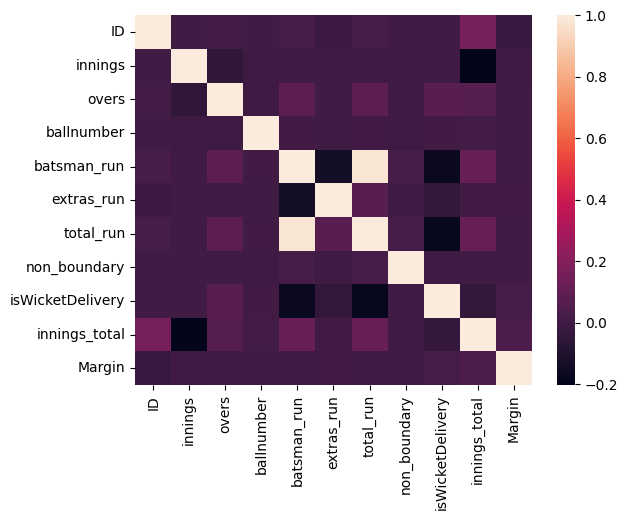

In [11]:
# Have a look at correlation
import seaborn as sns

sns.heatmap(complete_df.corr());

In [12]:
# To get more info have a look at the correlation matrix

complete_df.corr()

,ID,innings,overs,ballnumber,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,innings_total,Margin
ID,1.000000,0.002039,0.009295,0.001006,0.024467,-0.012086,0.022082,0.001513,-0.000873,0.160760,-0.025493
innings,0.002039,1.000000,-0.050497,-0.004535,-0.005425,0.000203,-0.005422,0.000765,0.000340,-0.203122,-0.003136
overs,0.009295,-0.050497,1.000000,-0.003695,0.084464,0.001674,0.085457,-0.001689,0.073935,0.066494,-0.000885
ballnumber,0.001006,-0.004535,-0.003695,1.000000,0.004527,0.000162,0.004596,-0.002286,0.004143,0.008423,0.001854
batsman_run,0.024467,-0.005425,0.084464,0.004527,1.000000,-0.140860,0.977595,0.019828,-0.170370,0.117252,0.002171
extras_run,-0.012086,0.000203,0.001674,0.000162,-0.140860,1.000000,0.070692,-0.001889,-0.041472,0.008330,0.003888
total_run,0.022082,-0.005422,0.085457,0.004596,0.977595,0.070692,1.000000,0.019575,-0.180473,0.119908,0.003015
non_boundary,0.001513,0.000765,-0.001689,-0.002286,0.019828,-0.001889,0.019575,1.000000,-0.002197,0.002767,0.002405
isWicketDelivery,-0.000873,0.000340,0.073935,0.004143,-0.170370,-0.041472,-0.180473,-0.002197,1.000000,-0.040252,0.019430
innings_total,0.160760,-0.203122,0.066494,0.008423,0.117252,0.008330,0.119908,0.002767,-0.040252,1.000000,0.040960


In [13]:
# complete_df.to_csv('../raw_data/complete_df.csv', index=False)

### Create some new features that might be useful when predicting match wins
- batsman average
- team innings average
- bowlers average (number_runs/number_wks)

Create the batsman's average. This can be done by adding up the number of runs they score in each innings and dividing it by the total number of innings. 

In [14]:
complete_df['batsman_average'] = complete_df.groupby('batter')['batsman_run'].transform('sum') / complete_df.groupby('batter')['ID'].transform('nunique')

complete_df.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'innings_total', 'City', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin', 'method',
       'Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1', 'Umpire2',
       'batsman_average'],
      dtype='object')

Create the teams total innings average in a similar fashion

In [15]:
complete_df['team_batting_average'] = complete_df.groupby('BattingTeam')['total_run'].transform('sum') / complete_df.groupby('BattingTeam')['ID'].transform('nunique')
complete_df.head(2)

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,...,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,batsman_average,team_batting_average
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,...,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906


<AxesSubplot:>

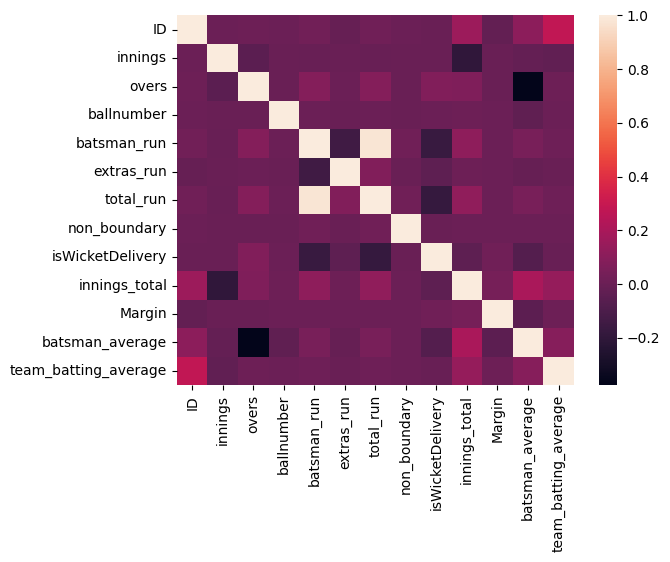

In [16]:
sns.heatmap(complete_df.corr())

In [17]:
complete_df.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'innings_total', 'City', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin', 'method',
       'Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1', 'Umpire2',
       'batsman_average', 'team_batting_average'],
      dtype='object')

In [18]:
complete_df['bowler_average'] = complete_df.groupby('bowler')['batsman_run'].transform('sum') / complete_df.groupby('bowler')['isWicketDelivery'].transform('sum')

In [19]:
complete_df.head(5)

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,...,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,batsman_average,team_batting_average,bowler_average
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906,23.991379
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,...,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906,23.991379
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,...,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,34.962963,155.397906,23.991379
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906,23.991379
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,23.782609,155.397906,23.991379


In [20]:
complete_df.columns


Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'innings_total', 'City', 'Date',
       'Season', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner',
       'TossDecision', 'SuperOver', 'WinningTeam', 'WonBy', 'Margin', 'method',
       'Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1', 'Umpire2',
       'batsman_average', 'team_batting_average', 'bowler_average'],
      dtype='object')

In [35]:
# Extract the relevant columns and rename 'Team1' to 'TeamA' and 'Team2' to 'TeamB'
selected_columns = ['ID', 'innings', 'Team1', 'Team2', 'team_batting_average', 'WinningTeam']
new_df = complete_df[selected_columns].copy()
new_df.rename(columns={'Team1': 'TeamA', 'Team2': 'TeamB'}, inplace=True)
new_df.head()

,ID,innings,TeamA,TeamB,team_batting_average,WinningTeam
0,1312200,1,Rajasthan Royals,Gujarat Titans,155.397906,Gujarat Titans
1,1312200,1,Rajasthan Royals,Gujarat Titans,155.397906,Gujarat Titans
2,1312200,1,Rajasthan Royals,Gujarat Titans,155.397906,Gujarat Titans
3,1312200,1,Rajasthan Royals,Gujarat Titans,155.397906,Gujarat Titans
4,1312200,1,Rajasthan Royals,Gujarat Titans,155.397906,Gujarat Titans


In [39]:
# Filter innings 1 (TeamA's innings)
team_a_data = new_df[new_df['innings'] == 1][['ID', 'TeamA', 'team_batting_average', 'WinningTeam']]
team_a_data.rename(columns={'TeamA': 'Team', 'team_batting_average': 'Team_batting_average'}, inplace=True)

# Filter innings 2 (TeamB's innings)
team_b_data = new_df[new_df['innings'] == 2][['ID', 'TeamB', 'team_batting_average']]
team_b_data.rename(columns={'TeamB': 'Team', 'team_batting_average': 'Team_batting_average_B'}, inplace=True)

# Merge the data from innings 1 and innings 2 for each match ID
merged_data = pd.merge(team_a_data, team_b_data, on='ID')

# Display the resulting DataFrame
merged_data.head(20)

,ID,Team_x,Team_batting_average,WinningTeam,Team_y,Team_batting_average_B
0,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
1,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
2,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
3,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
4,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
5,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
6,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
7,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
8,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375
9,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.4375


In [41]:
# Drop duplicates based on 'ID' column and keep the first occurrence
final_data = merged_data.drop_duplicates(subset='ID', keep='first')

# Reset the index
final_data.reset_index(drop=True, inplace=True)
final_data.head()

,ID,Team_x,Team_batting_average,WinningTeam,Team_y,Team_batting_average_B
0,1312200,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.437500
1,1312199,Royal Challengers Bangalore,155.707965,Rajasthan Royals,Rajasthan Royals,155.397906
2,1312198,Royal Challengers Bangalore,155.707965,Royal Challengers Bangalore,Lucknow Super Giants,169.866667
3,1312197,Rajasthan Royals,155.397906,Gujarat Titans,Gujarat Titans,166.437500
4,1304116,Sunrisers Hyderabad,155.546053,Punjab Kings,Punjab Kings,160.464286


In [44]:
# Create file name to save as
file_name = '../raw_data/match_result_averages.csv'

# Export to a csv file
final_data.to_csv(file_name, index=False)

Feature engineering:
Create relevant features: Extract features that might be relevant for predicting match outcomes. For example, you might calculate batting averages, bowling averages, team win rates, player statistics, and so on.
Consider feature interactions: Create new features that capture potential interactions between existing features.
Model Selection:

Choose a model: Decide on the type of model to use. Popular choices for predicting outcomes include logistic regression, decision trees, random forests, gradient boosting, and neural networks.
Split the data: Divide your dataset into training and testing sets.
Model Training:

Train the model: Fit your chosen model on the training data.
Hyperparameter tuning: Experiment with different hyperparameters to optimize the model's performance.
Model Evaluation:

Evaluate on training data: Assess the model's performance on the training data. Keep in mind that this is not the final evaluation.
Cross-validation: Use techniques like k-fold cross-validation to get a better estimate of your model's performance on unseen data.
Model Testing and Interpretation:

Evaluate on testing data: Finally, assess the model's performance on the testing data. This will give you an estimate of how well your model generalizes to new, unseen data.
Feature importance: If applicable, analyze the feature importance to understand which features contribute the most to the predictions.
Model Deployment:

If the model performs well, you can deploy it to make predictions on new matches. This could be done via a web application, API, or any other suitable method.
Iterate and Improve:

Continuously monitor and evaluate your model's performance. If it's not performing as expected, consider re-evaluating your features, trying different models, or collecting additional relevant data.